# KNN model for predicting racket type using datasets P1, P2, and P3, based on **envelope** - Sound

### Model Description

This notebook implements a K-Nearest Neighbors (KNN) model to predict the type of a racket (RB, RO, RR, RV) based on sound features extracted from audio files. The workflow involves reading `.wav` files, **envelope** using FFT, and training the model using these features. The model's performance is evaluated using accuracy metrics and visualized through scatter plots and a confusion matrix.

### Import libraries

In [2]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# import openpyxl


### Import Tools Functions

In [3]:
import sys
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

['P1_RB_1_C_1.wav', 'P1_RB_1_C_2.wav', 'P1_RB_1_C_3.wav', 'P1_RB_1_S_1.wav', 'P1_RB_1_S_2.wav', 'P1_RB_1_S_3.wav', 'P1_RB_1_V_1.wav', 'P1_RB_1_V_2.wav', 'P1_RB_1_V_3.wav', 'P1_RB_2_C_1.wav', 'P1_RB_2_C_2.wav', 'P1_RB_2_C_3.wav', 'P1_RB_2_S_1.wav', 'P1_RB_2_S_2.wav', 'P1_RB_2_S_3.wav', 'P1_RB_2_V_1.wav', 'P1_RB_2_V_2.wav', 'P1_RB_2_V_3.wav', 'P1_RB_3_C_1.wav', 'P1_RB_3_C_2.wav', 'P1_RB_3_C_3.wav', 'P1_RB_3_S_1.wav', 'P1_RB_3_S_2.wav', 'P1_RB_3_S_3.wav', 'P1_RB_3_V_1.wav', 'P1_RB_3_V_2.wav', 'P1_RB_3_V_3.wav', 'P1_RB_4_C_1.wav', 'P1_RB_4_C_2.wav', 'P1_RB_4_C_3.wav', 'P1_RB_4_S_1.wav', 'P1_RB_4_S_2.wav', 'P1_RB_4_S_3.wav', 'P1_RB_4_V_1.wav', 'P1_RB_4_V_2.wav', 'P1_RB_4_V_3.wav', 'P1_RB_5_C_1.wav', 'P1_RB_5_C_2.wav', 'P1_RB_5_C_3.wav', 'P1_RB_5_S_1.wav', 'P1_RB_5_S_2.wav', 'P1_RB_5_S_3.wav', 'P1_RB_5_V_1.wav', 'P1_RB_5_V_2.wav', 'P1_RB_5_V_3.wav', 'P1_RB_6_C_1.wav', 'P1_RB_6_C_2.wav', 'P1_RB_6_C_3.wav', 'P1_RB_6_S_1.wav', 'P1_RB_6_S_2.wav', 'P1_RB_6_S_3.wav', 'P1_RB_6_V_1.wav', 'P1_RB_6_V_

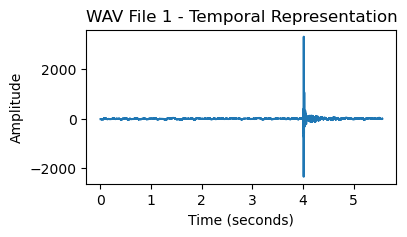

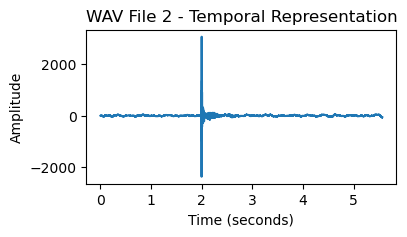

In [4]:
from readWavFolder import readWavFolder
    
samplerateVect,testWavFileVect,filename = readWavFolder("../../../Data/Sound/P1/")
print(filename)
for i, wav_data in enumerate(testWavFileVect[:2]):
    plt.figure(figsize=(4, 2))
    time_axis = [x / samplerateVect[i] for x in range(len(wav_data))]
    plt.plot(time_axis, wav_data[:, 0])  # Plot only the first channel
    plt.title(f"WAV File {i + 1} - Temporal Representation")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()


Spectrum

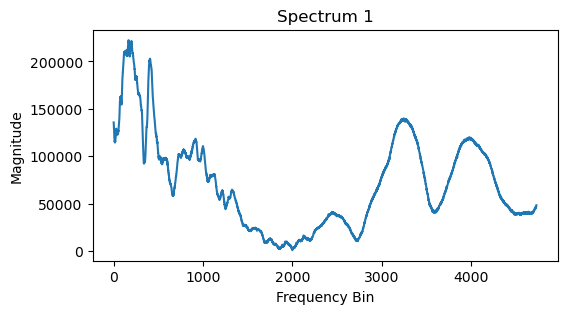

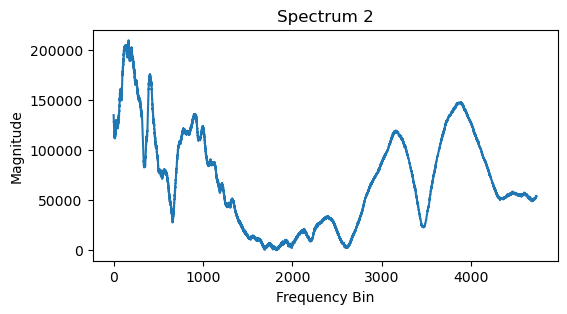

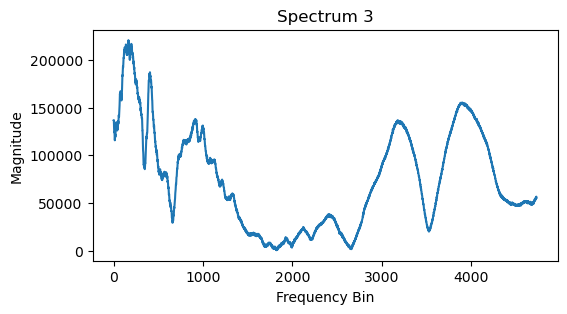

In [5]:
from spectrumFromSignal import spectrumFromSignal


spectrumVect=[]
spectrumVectFreqs=[]
for i in range(len(testWavFileVect)):
    spectrum,freqs = spectrumFromSignal(testWavFileVect[i], samplerateVect[i])
    spectrumVect.append(spectrum)
    spectrumVectFreqs.append(freqs)

for idx, spectrum in enumerate(spectrumVect[:3]):
    plt.figure(figsize=(6, 3))
    plt.plot(spectrum)
    plt.title(f"Spectrum {idx + 1}")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.show()



Peaks

In [6]:
from envelope_from_signal import envelope_from_signal

## Main

In [ ]:
raquetteTypeList = {"RB": 0, "RO": 1, "RR": 2, "RV": 3}
used = False
bd=15

# Liste pour stocker les résultats
results = []


X=[]
Y_Label = []

    

# Create a DataFrame to store details of each wav file
wav_files_data = []

# Process each folder (P1, P2, P3)
for folder, folder_path in [("P1", "../../../Data/Sound/P1"), 
                            ("P2", "../../../Data/Sound/P2"), 
                            ("P3", "../../../Data/Sound/P3")]:
    sample_rates, wav_files, file_names = readWavFolder(folder_path)
    
    for sample_rate, wav_file, file_name in zip(sample_rates, wav_files, file_names):
        wav_files_data.append({
            "Folder": folder,
            "File_Name": file_name,
            "Sample_Rate": sample_rate,
            "Signal": wav_file
        })

# Convert the list of dictionaries into a DataFrame
wav_files_df = pd.DataFrame(wav_files_data)

# Display the DataFrame
# print(wav_fsiles_df)



# Pour chaque fichier wav on extrait son spectre et on le filtre entre 150 et 1000hz et on prend les n meilleurs peaks
for i in range(len(wav_files_df["Signal"])):
    if "C" in wav_files_df["File_Name"][i]:
        if 'RB' in wav_files_df["File_Name"][i]:
            raquetteType = 'RB'
        elif 'RR' in wav_files_df["File_Name"][i]:
            raquetteType = 'RR'
        elif 'RO' in wav_files_df["File_Name"][i]:
            raquetteType = 'RO'
        elif 'RV' in wav_files_df["File_Name"][i]:
            raquetteType = 'RV'
            
        spectrum,freqs = spectrumFromSignal(wav_files_df["Signal"][i], wav_files_df["Sample_Rate"][i])
        # spectrumVect.append(spectrum) 

        envelope = envelope_from_signal(wav_files_df["Signal"][i][:, 0])
        # print(envelope)

        X.append(envelope)

        Y_Label.append(raquetteType)


# Ensure each element of X has the same length by padding or truncating
max_length = max(len(x) for x in X)
X = [x[:max_length] if len(x) > max_length else np.pad(x, (0, max_length - len(x)), mode='constant') for x in X]
# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y_Label)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)
# Définir les plages de valeurs pour les hyperparamètres
n_neighbors_range = range(1, 21)  # Nombre de voisins
weights_options = ['uniform', 'distance']  # Méthode de pondération
metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  # Métriques

# Tester toutes les combinaisons d'hyperparamètres
for n_neighbors in n_neighbors_range:
    for weights in weights_options:
        for metric in metric_options:
            # Créer et entraîner le modèle KNN
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            knn.fit(X_train, y_train)

            # Évaluer sur l'ensemble de test
            y_pred = knn.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)

            # Évaluer sur l'ensemble d'entraînement
            y_train_pred = knn.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)

            # Switch case for channel
            if c == 0:
                channel_name = "Left"
            elif c == 1:
                channel_name = "Right"
            
            # Add channel name to results
            results.append({
                'Chanel_Name': channel_name,
                'band_width': bd,
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)


    

Chanel 0


## Results and Visualisation

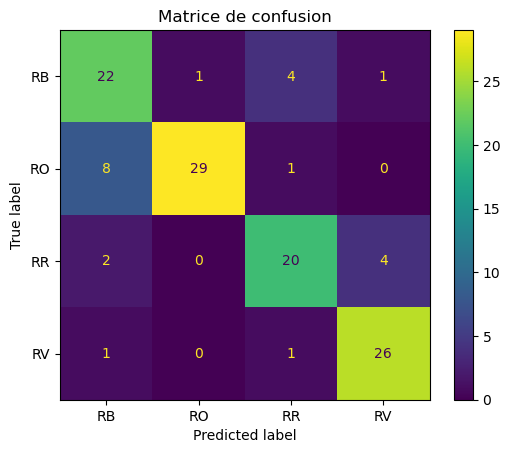

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()

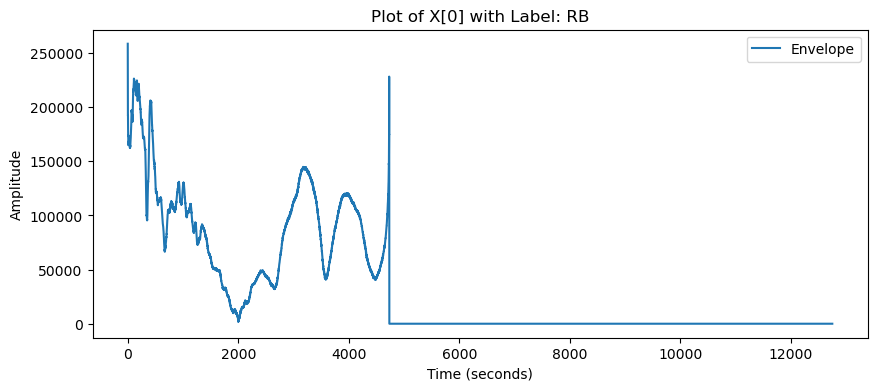

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(X[0], label="Envelope")
plt.title(f"Plot of X[0] with Label: {label_encoder.inverse_transform([y[0]])[0]}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()